### Utimate Data Science Challenge
This project consists of three parts. The purpose of this project is to analyze user login activity and identify new metrics to use for modeling. 

Below is the outline:

## Part 1

1. Preliminary Data Analyses
2. Data Wrangling
3. Exploratory Data Analyses (EDA)
4. Model Building

In [217]:
# Import Libraries

import os
import sys
import warnings
import json

import numpy as np 
import pandas as pd 
import seaborn as sns
import lightgbm as lgb
import scipy.stats as stats
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

from yellowbrick.classifier import ROCAUC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

In [218]:
# Load historical data 
data=pd.read_json('logins.json')

# Part 1

The   attached   logins.json     file   contains   (simulated)   timestamps   of   user   logins   in   a   particular 
geographic   location.   Aggregate   these   login   counts   based   on   15­ minute   time   intervals,   and 
visualize   and   describe   the   resulting   time   series   of   login   counts   in   ways   that   best   characterize   the 
underlying   patterns   of   the   demand.   Please   report/illustrate   important   features   of   the   demand, 
such   as   daily   cycles.   If   there   are   data   quality   issues,   please   report   them. 

## Preliminary Data Analyses

In this section, we will explore given data to find missing values and learn how many features/samles we have

In [219]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [220]:
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [221]:
additional_info=pd.DataFrame(data.dtypes).T.rename(index={0:'column type'})
additional_info=additional_info.append(pd.DataFrame(data.isnull().sum()).T.rename(index={0:'null values (nb)'}))
additional_info=additional_info.append(pd.DataFrame(data.isnull().sum()/data.shape[0]*100)
                         .T.rename(index={0:'null values (%)'}))
additional_info.T

,column type,null values (nb),null values (%)
login_time,datetime64[ns],0,0


## Data Wrangling

In [222]:
#Extract date/time from converted time feature (created_at) and create new features for date and time
data['login_time'] = pd.to_datetime(data['login_time'])

In [223]:
new = data
new.set_index('login_time', inplace=True)
new['count'] = 1
new=new.resample('15T', how='sum').reset_index()

In [224]:
data.reset_index(inplace=True)

In [225]:
#Create new features for days of week and daily hours
data['date'] = data['login_time'].dt.date
data['time'] = data['login_time'].dt.time
data['year'] = data['login_time'].dt.year
data['month'] = data['login_time'].dt.month
data['hours'] = data['login_time'].dt.hour
data['day'] = data['login_time'].dt.day
data['week'] = data['login_time'].dt.week
data['week_day'] = data['login_time'].dt.weekday

In [226]:
#Create new features for days of week and daily hours
new['date'] = new['login_time'].dt.date
new['time'] = new['login_time'].dt.time
new['year'] = new['login_time'].dt.year
new['month'] = new['login_time'].dt.month
new['hours'] = new['login_time'].dt.hour
new['day'] = new['login_time'].dt.day
new['week'] = new['login_time'].dt.week
new['week_day'] = new['login_time'].dt.weekday

In [227]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 10 columns):
login_time    93142 non-null datetime64[ns]
count         93142 non-null int64
date          93142 non-null object
time          93142 non-null object
year          93142 non-null int64
month         93142 non-null int64
hours         93142 non-null int64
day           93142 non-null int64
week          93142 non-null int64
week_day      93142 non-null int64
dtypes: datetime64[ns](1), int64(7), object(2)
memory usage: 7.1+ MB


## Exploratory Data Analyses (EDA)


### 15 minutes interval login plot

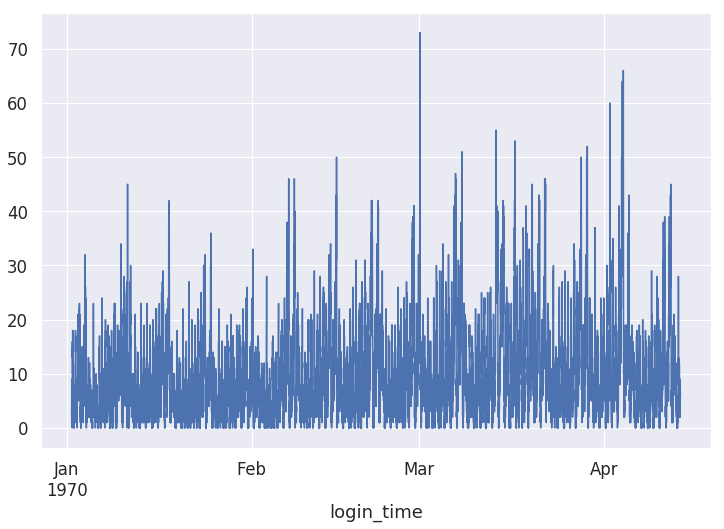

In [228]:
# Plot time
plt.figure(figsize=(12,8))
new.set_index('login_time', inplace=True)
new['count'].plot()

### Daily interval login 

(array([719160., 719163., 719177., 719191., 719194., 719208., 719222.,
        719236., 719250., 719253., 719267.]),
 <a list of 11 Text xticklabel objects>)

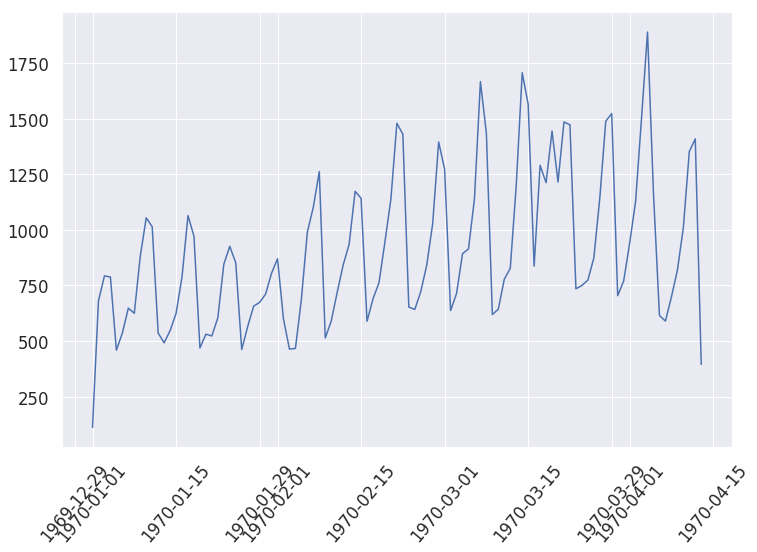

In [229]:
# Plot time
plt.figure(figsize=(12,8))
#new.set_index('login_time', inplace=True)
data['date'].value_counts().sort_index().plot()
plt.xticks(rotation = 50)


### Daily 15 minute aggregated user activity

We will investigate daily (Mon-Sun) user login activity to identify some patterns.

In [230]:
data=data.reset_index()

In [231]:
# Aggregate 15 minute aggregated data by time, count and week day
gr=new.groupby(["time", "count", "week_day"]).aggregate("count").reset_index()

In [232]:
# Create Mon-Sun aggregated data
Mon=gr[gr.week_day == 0].groupby('time')['count'].aggregate('sum').reset_index()
Tue=gr[gr.week_day == 1].groupby('time')['count'].aggregate('sum').reset_index()
Wen=gr[gr.week_day == 2].groupby('time')['count'].aggregate('sum').reset_index()
Thu=gr[gr.week_day == 3].groupby('time')['count'].aggregate('sum').reset_index()
Fri=gr[gr.week_day == 4].groupby('time')['count'].aggregate('sum').reset_index()
Sat=gr[gr.week_day == 5].groupby('time')['count'].aggregate('sum').reset_index()
Sun=gr[gr.week_day == 6].groupby('time')['count'].aggregate('sum').reset_index()

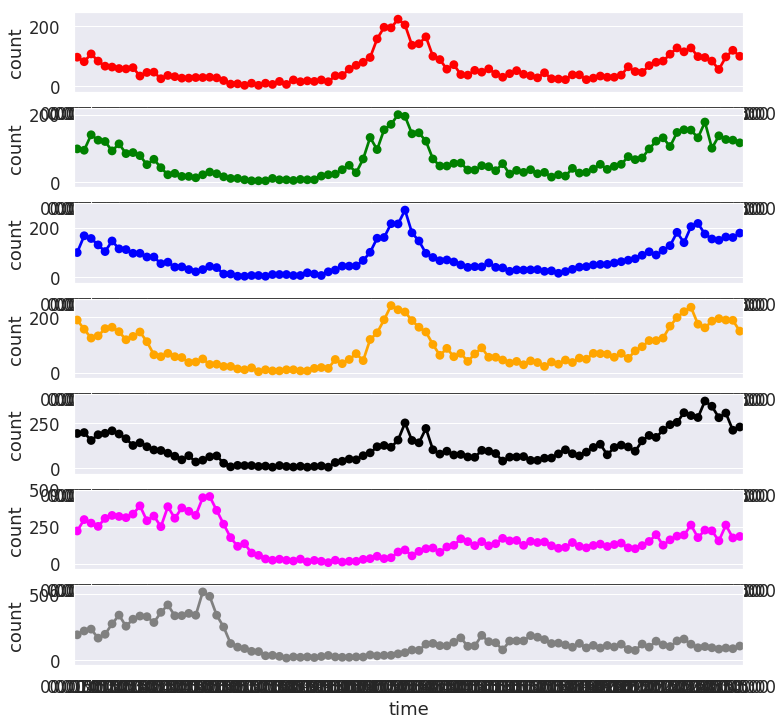

In [233]:
# Plot the data
import matplotlib.dates as mdates

hour = Mon['time']
fig, axes = plt.subplots(7, 1,figsize=(12,12))
plt.rcParams['font.size'] = 12.0

'''
idx = pd.date_range('2017-01-01 00:00', '2017-04-13 23:59', freq = 'min')
df = pd.Series(np.random.randn(len(idx)),  index = idx)

hours = mdates.HourLocator(interval = 1)
h_fmt = mdates.DateFormatter('%H:%M:%S')

axes[0].xaxis.set_major_locator(hours)
axes[0].xaxis.set_major_formatter(h_fmt)
'''

a=sns.pointplot(hour, Mon['count'], alpha=0.8, color='red', ax=axes[0])
b=sns.pointplot(hour, Tue['count'], alpha=0.8, color='green', ax=axes[1])
c=sns.pointplot(hour, Wen['count'], alpha=0.8, color='blue', ax=axes[2])
d=sns.pointplot(hour, Thu['count'], alpha=0.8, color='orange', ax=axes[3])
e=sns.pointplot(hour, Fri['count'], alpha=0.8, color='black', ax=axes[4])
f=sns.pointplot(hour, Sat['count'], alpha=0.8, color='magenta', ax=axes[5])
g=sns.pointplot(hour, Sun['count'], alpha=0.8, color='gray', ax=axes[6])

We can see from the above plot that Monday-Friday had 12 hour cycling peaks for login for 15 min aggregated time. Saturday-Sunday showed different behaviour, which indicates that users prefer to login at night time on weekend.

### Exploratory Data Analyses

In this section we will study the 

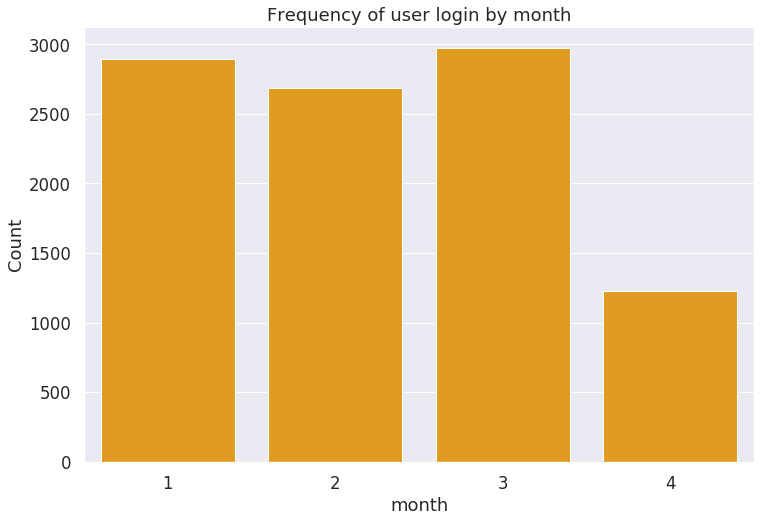

In [234]:
# Plot the frequency per month

plt.figure(figsize=(12,8))
sns.countplot(x="month", data=new, color='orange')
plt.ylabel('Count', fontsize=18)
plt.xlabel('month', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title("Frequency of user login by month", fontsize=18)
plt.show()

Overall, there were more logins in March and January, a little bit less in February and even less logins in April.

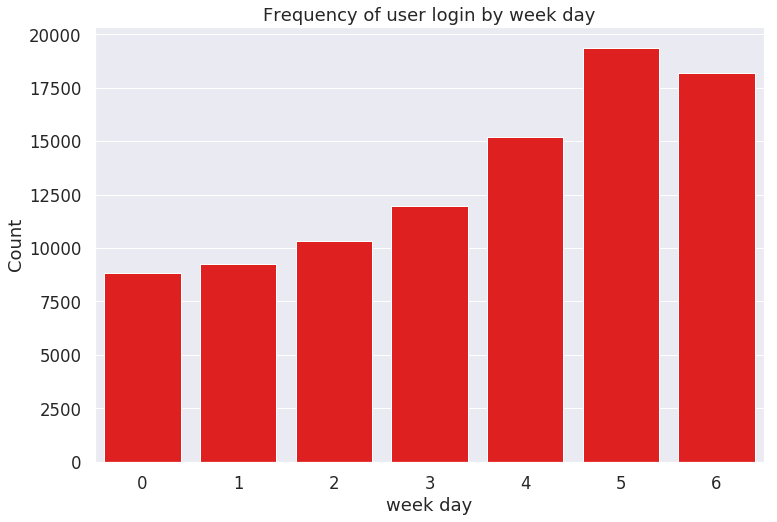

In [235]:
# Plot the frequency per week day

plt.figure(figsize=(12,8))
sns.countplot(x="week_day", data=data, color='red')
plt.ylabel('Count', fontsize=18)
plt.xlabel('week day', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title("Frequency of user login by week day", fontsize=18)
plt.show()

From the graph above we see that login number increases towards the end of a week. 

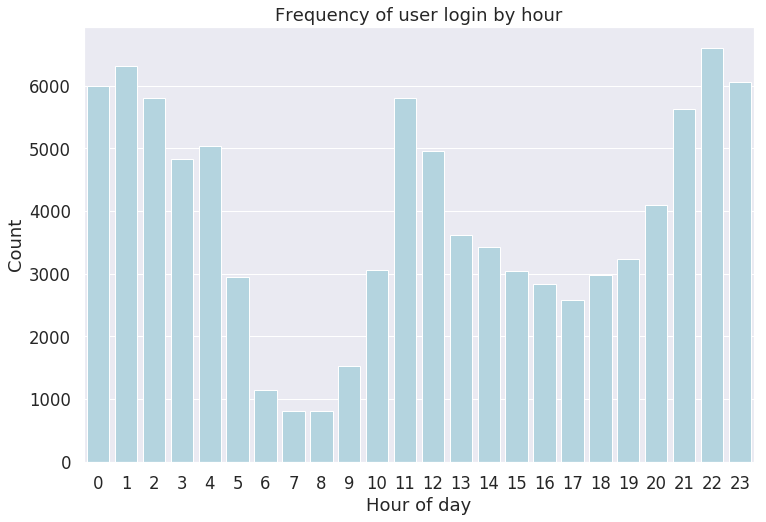

In [236]:
# Plot the frequency of orders per week day

plt.figure(figsize=(12,8))
sns.countplot(x="hours", data=data, color='lightblue')
plt.ylabel('Count', fontsize=18)
plt.xlabel('Hour of day', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title("Frequency of user login by hour", fontsize=18)
plt.show()

Hourly activity reveals that users login more at night and lunch hours.

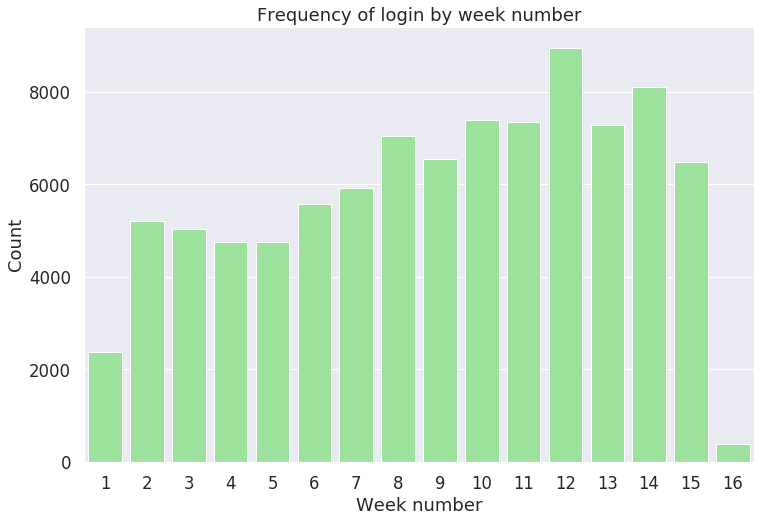

In [237]:
# Count the time when orders are made

plt.figure(figsize=(12,8))
sns.countplot(x="week", data=data, color='lightgreen')
plt.ylabel('Count', fontsize=18)
plt.xlabel('Week number', fontsize=18)
plt.xticks(rotation='horizontal')
plt.title("Frequency of login by week number", fontsize=18)
plt.show()

More logins take place as number of weeks increases.

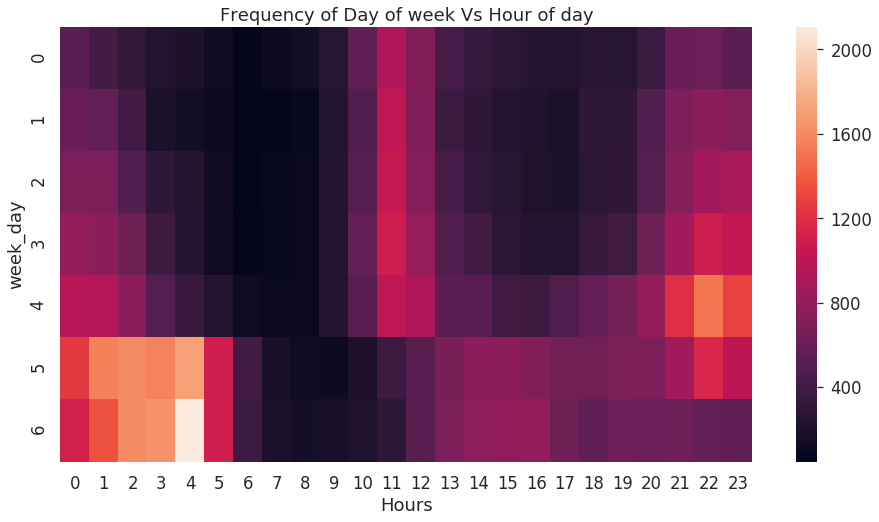

In [238]:
grouped_df = data.groupby(["week_day", "hours"])["date"].aggregate("count").reset_index()
grouped_df = grouped_df.pivot('week_day', 'hours', 'date')

plt.figure(figsize=(15.5,8))
sns.heatmap(grouped_df)
plt.xlabel('Hours')
plt.title("Frequency of Day of week Vs Hour of day")
plt.show()

# Part 2

The   neighboring   cities   of   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on 
weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active 
during   the   day.   On   weekends,   there   is   reasonable   activity   in   both   cities. 
 
However,   a   toll   bridge,   with   a   two ­way   toll,   between   the   two   cities   causes   driver   partners   to   tend 
to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have 
proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by 
reimbursing   all   toll   costs. 
1. What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in 
encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric? 
2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the 
proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on:  
a. how   you   will   implement   the   experiment 
b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the 
observation 
c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city 
operations   team   along   with   any   caveats. 

### Answers:

1. As a key measure of success of the experiment in encouraging partners to serve both ciries, we could use driver's conversion rate. Presumably, inter city driving will bring more profit to drivers. Other metrics could include: passanger wait time in both cities and income to the city budget from increased number of rides.     

2. a) I would propose to compare the driver conversion rate between two groups. 
   b) First one will be the controlled group and the other will be the test group. First, we could check the distribution of income for both groups to find whether they are normally distributed or not. In case of normal distrubution, we could use t-test to determine if the difference between them is statistically significant. Otherwise, we could use other statistical test, such as Mann–Whitney U-test. 
   c) Use Null hypothesis with 0.05 alhpa parameter to determine the significance of the difference between conversion rates of these two groups. If there is statistically significant difference, recommend to use the appropriate change from the metrics.

# Part 3

Ultimate   is   interested   in   predicting   rider   retention.   To   help   explore   this   question,   we   have 
provided   a   sample   dataset   of   a   cohort   of   users   who   signed   up   for   an   Ultimate   account   in January   2014.   The   data   was   pulled   several   months   later;   we   consider   a   user   retained   if   they 
were   “active”   (i.e.   took   a   trip)   in   the   preceding   30   days. 
 
We   would   like   you   to   use   this   data   set   to   help   understand   what   factors   are   the   best   predictors 
for   retention,   and   offer   suggestions   to   operationalize   those   insights   to   help   Ultimate. 
 
The   data   is   in   the   attached   file   ultimate_data_challenge.json.   See   below   for   a   detailed 
description   of   the   dataset.   Please   include   any   code   you   wrote   for   the   analysis   and   delete   the 
dataset   when   you   have   finished   with   the   challenge. 
 
1. Perform   any   cleaning,   exploratory   analysis,   and/or   visualizations   to   use   the   provided 
data   for   this   analysis   (a   few   sentences/plots   describing   your   approach   will   suffice).   What 
fraction   of   the   observed   users   were   retained? 
2. Build   a   predictive   model   to   help   Ultimate   determine   whether   or   not   a   user   will   be   active 
in   their   6th   month   on   the   system.   Discuss   why   you   chose   your   approach,   what 
alternatives   you   considered,   and   any   concerns   you   have.   How   valid   is   your   model? 
Include   any   key   indicators   of   model   performance. 
3. Briefly   discuss   how   Ultimate   might   leverage   the   insights   gained   from   the   model   to 
improve   its   long­ term   rider   retention   (again,   a   few   sentences   will   suffice). 

In [239]:
with open('ultimate_data_challenge.json') as line:
    ultimate_data = json.load(line)

ultimate_data = pd.DataFrame(ultimate_data)

ultimate_data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [240]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [241]:
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])
ultimate_data['signup_date'] = pd.to_datetime(ultimate_data['signup_date'])


In [242]:
ultimate_data.describe().T

,count,mean,std,min,25%,50%,75%,max
avg_dist,50000.0,5.796827,5.707357,0.0,2.42,3.88,6.94,160.96
avg_rating_by_driver,49799.0,4.778158,0.446652,1.0,4.70,5.00,5.00,5.00
avg_rating_of_driver,41878.0,4.601559,0.617338,1.0,4.30,4.90,5.00,5.00
avg_surge,50000.0,1.074764,0.222336,1.0,1.00,1.00,1.05,8.00
surge_pct,50000.0,8.849536,19.958811,0.0,0.00,0.00,8.60,100.00
trips_in_first_30_days,50000.0,2.278200,3.792684,0.0,0.00,1.00,3.00,125.00
weekday_pct,50000.0,60.926084,37.081503,0.0,33.30,66.70,100.00,100.00


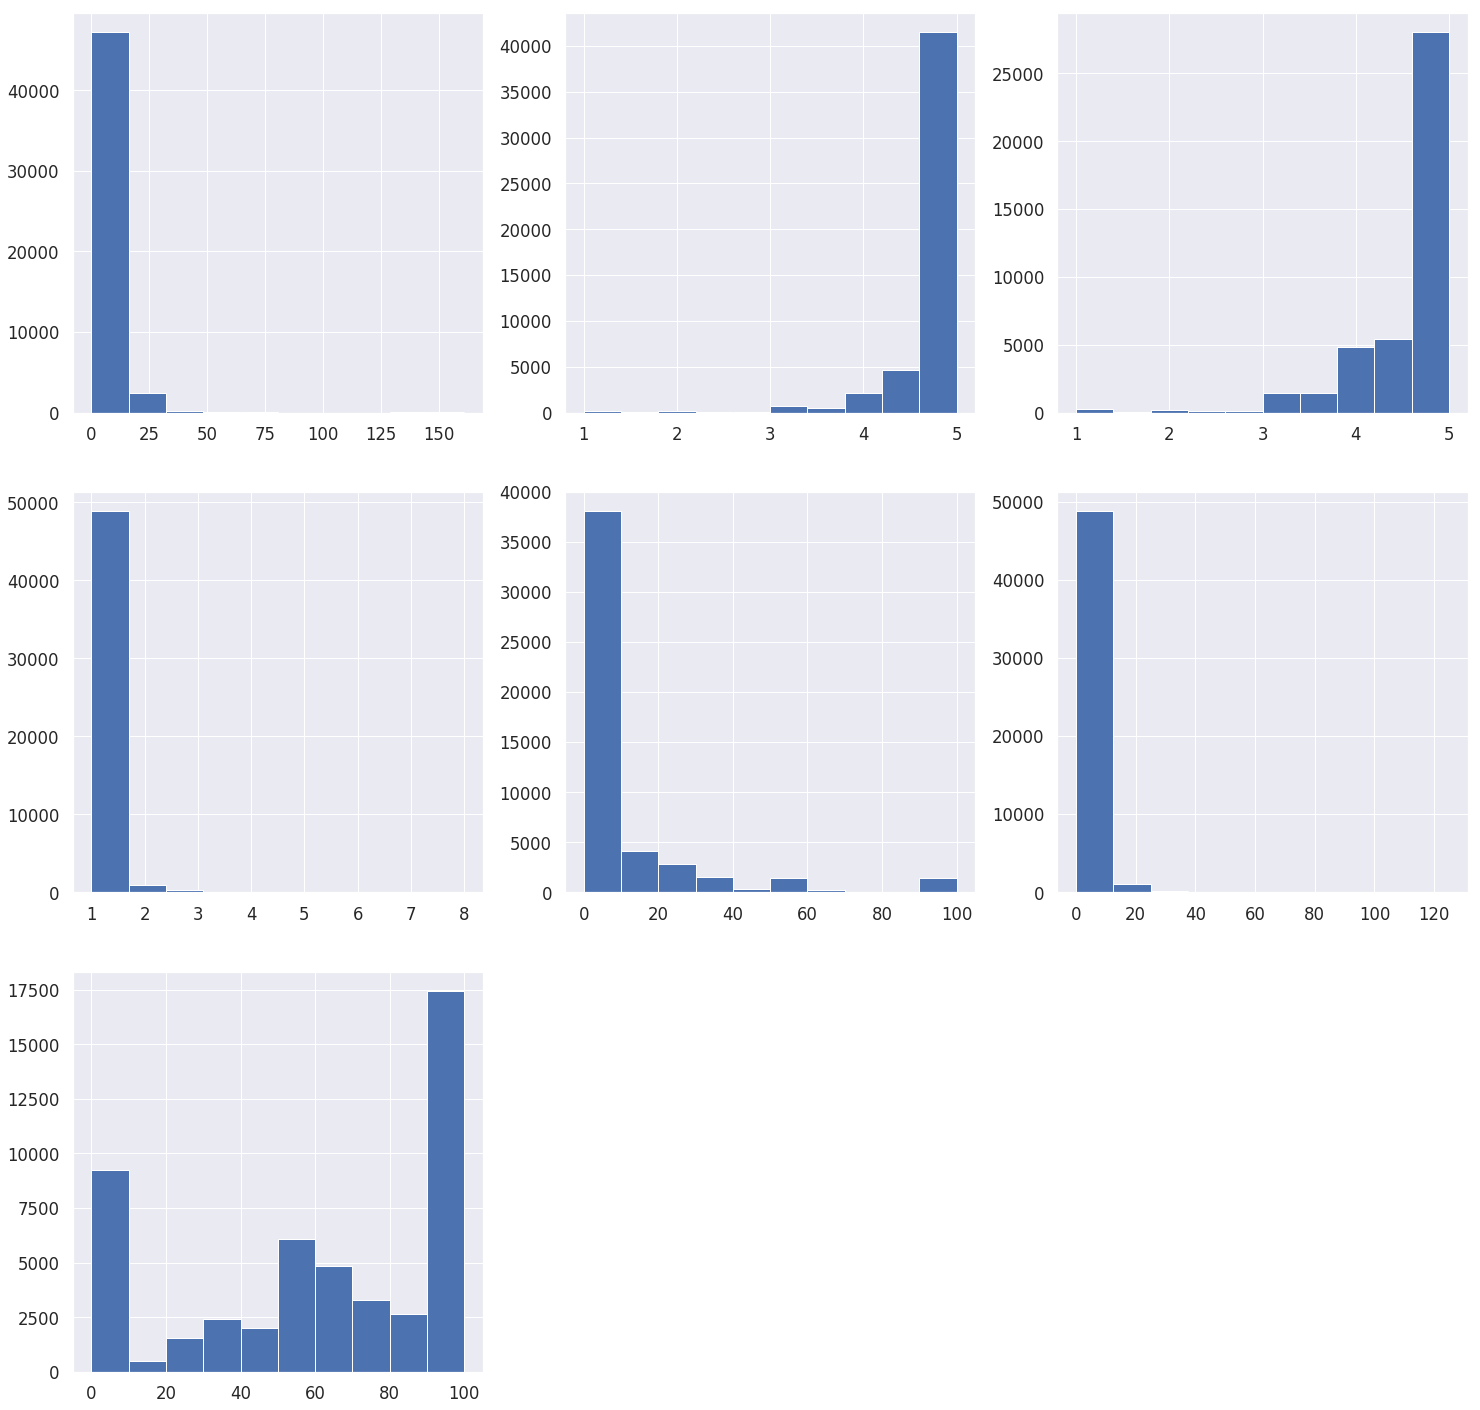

In [243]:
fig = plt.figure(figsize = (25,25))  
sns.set(font_scale=1.5) 

cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

for idx, val in enumerate(cols):
    plt.subplot(3, 3, idx+1)
    ultimate_data[val].hist()

We can clearly see that data is right and left skewed, which indicates on possible outliers. We will drop lower 2.5 and upper 97.5 percentiles of values from data to reduce outliers. 

In [244]:
# fill missing avg_rating_by_driver and avg_rating_of_driver with mean value     
ultimate_data['avg_rating_by_driver']=ultimate_data['avg_rating_by_driver'].fillna(ultimate_data['avg_rating_by_driver'].mean())
ultimate_data['avg_rating_of_driver']=ultimate_data['avg_rating_of_driver'].fillna(ultimate_data['avg_rating_of_driver'].mean())

In [245]:
# drop data in upper 97.5 and lower 2.5 percentiles to reduce outliers
for col in cols:

    Q_0250 = ultimate_data[col].quantile(0.025)
    Q_0975 = ultimate_data[col].quantile(0.975)
    IQR = Q_0975-Q_0250
    lower_bound = Q_0250 - 1.5*IQR
    upper_bound = Q_0975 + 1.5*IQR

    ultimate_data=ultimate_data[ultimate_data[col] > lower_bound]
    ultimate_data=ultimate_data[ultimate_data[col] < upper_bound]

In [246]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49494 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49494 non-null float64
avg_rating_by_driver      49494 non-null float64
avg_rating_of_driver      49494 non-null float64
avg_surge                 49494 non-null float64
city                      49494 non-null object
last_trip_date            49494 non-null datetime64[ns]
phone                     49103 non-null object
signup_date               49494 non-null datetime64[ns]
surge_pct                 49494 non-null float64
trips_in_first_30_days    49494 non-null int64
ultimate_black_user       49494 non-null bool
weekday_pct               49494 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.6+ MB


In [247]:
ultimate_data.dropna(inplace=True)

In [248]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49103 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  49103 non-null float64
avg_rating_by_driver      49103 non-null float64
avg_rating_of_driver      49103 non-null float64
avg_surge                 49103 non-null float64
city                      49103 non-null object
last_trip_date            49103 non-null datetime64[ns]
phone                     49103 non-null object
signup_date               49103 non-null datetime64[ns]
surge_pct                 49103 non-null float64
trips_in_first_30_days    49103 non-null int64
ultimate_black_user       49103 non-null bool
weekday_pct               49103 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.5+ MB


In [249]:
# create a list for active users
active_list = [False for x in range(0, len(ultimate_data))]

# find maximum day difference in last_trip_date and set minimum day difference to 30 days
max_days_delta = (ultimate_data['last_trip_date'].dt.month.max() - ultimate_data['last_trip_date'].dt.month.min())*30
max_days_delta = str(max_days_delta) + 'D'
min_days_delta = '30D'

for i in range(len(ultimate_data)):
    
    initial_date = ultimate_data['signup_date'].iloc[i]
    latest_date = initial_date + pd.Timedelta(max_days_delta)
    preceding = latest_date - pd.Timedelta(min_days_delta)

# we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days. 
    if preceding <= ultimate_data['last_trip_date'].iloc[i]:
        if ultimate_data['last_trip_date'].iloc[i] <= latest_date:
            active_list[i] = True
            
# create new feature active users 
ultimate_data['active'] = active_list

In [250]:
# drop unneccesary features and create new features from categorical variables
ultimate_data.drop(['last_trip_date', 'signup_date'], axis=1, inplace=True)
ultimate_data = pd.get_dummies(ultimate_data, drop_first=False)

In [251]:
# modify active & ultimate_black_user features from False, True (boolean) to 0, 1 (binary)
ultimate_data['active']=(ultimate_data['active']).astype(int)
ultimate_data['ultimate_black_user']=(ultimate_data['ultimate_black_user']).astype(int)

# check the active users feature to find how many active and non active users it includes
active, non_active = ultimate_data['active'].value_counts()

info=['Non active users', 'Active users']
count=[active, non_active]

df_users=pd.DataFrame({'User Info': info, 'Count': count})

In [252]:
df_users

,Count,User Info
0,36575,Non active users
1,12528,Active users


The 'active' user feature is not balanced. We will apply SMOTE oversampling technique to balance it.

In [253]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49103 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  49103 non-null float64
avg_rating_by_driver      49103 non-null float64
avg_rating_of_driver      49103 non-null float64
avg_surge                 49103 non-null float64
surge_pct                 49103 non-null float64
trips_in_first_30_days    49103 non-null int64
ultimate_black_user       49103 non-null int64
weekday_pct               49103 non-null float64
active                    49103 non-null int64
city_Astapor              49103 non-null uint8
city_King's Landing       49103 non-null uint8
city_Winterfell           49103 non-null uint8
phone_Android             49103 non-null uint8
phone_iPhone              49103 non-null uint8
dtypes: float64(6), int64(3), uint8(5)
memory usage: 4.0 MB


In [254]:
# split data to train/test samples

target = 'active'

X = ultimate_data.drop(target, axis=1).values
y = ultimate_data[target].values

df_columns = ultimate_data.drop(target, axis=1).columns.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify=y)

Accuracy of random forest classifier on test set: 0.78
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     10973
           1       0.57      0.57      0.57      3758

   micro avg       0.78      0.78      0.78     14731
   macro avg       0.71      0.71      0.71     14731
weighted avg       0.78      0.78      0.78     14731

Confusion Matrix:
[[9342 1631]
 [1604 2154]]


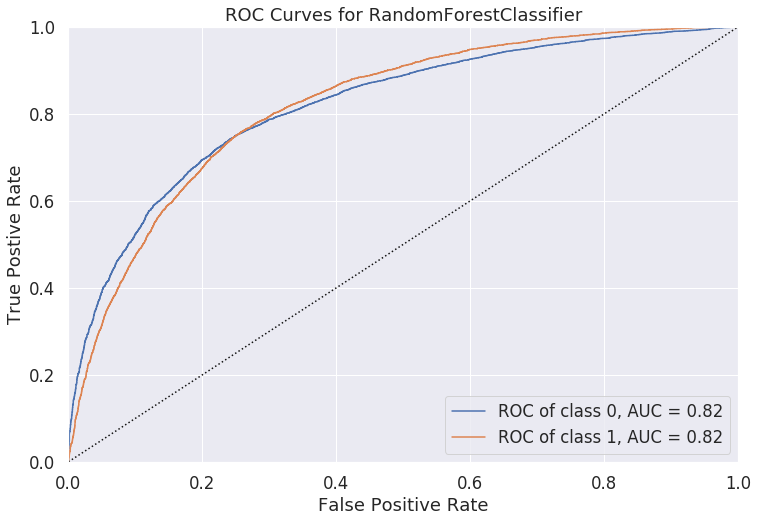

In [255]:
# use random forest classifier and SMOTE oversampling

parameters = {'n_estimators':[200, 400, 600, 800, 1000], 'min_samples_leaf':[4, 8, 16], 'max_features': ['auto', 'sqrt']}
rfc = RandomForestClassifier(random_state=42, min_samples_split=5, oob_score=True)

sm = SMOTE(random_state=0, sampling_strategy=1.0, k_neighbors=7, n_jobs=-1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

scoring = make_scorer(accuracy_score, greater_is_better=True)

cl_rand_fr = GridSearchCV(rfc, param_grid=parameters, cv=3, n_jobs=-1, scoring='f1')
cl_rand_fr.fit(X_train_res, y_train_res)
cl_rand_fr = cl_rand_fr.best_estimator_

# Show prediction accuracy score
print ('Accuracy of random forest classifier on test set: {:.2f}'.format(accuracy_score(y_test, cl_rand_fr.predict(X_test))))
print ("Classification report:\n{}".format(classification_report(y_test,cl_rand_fr.predict(X_test))))    
print("Confusion Matrix:\n{}".format(confusion_matrix(y_test, cl_rand_fr.predict(X_test))))
    
fig, ax=plt.subplots(1,1,figsize=(12,8))

auc=ROCAUC(cl_rand_fr, macro=False, micro=False)
auc.fit(X_train, y_train)
auc.score(X_test, y_test)
auc.poof()
                
precision,recall,fscore,support=score(y_test, cl_rand_fr.predict(X_test))

Text(0.5, 1.0, 'Feature Significance')

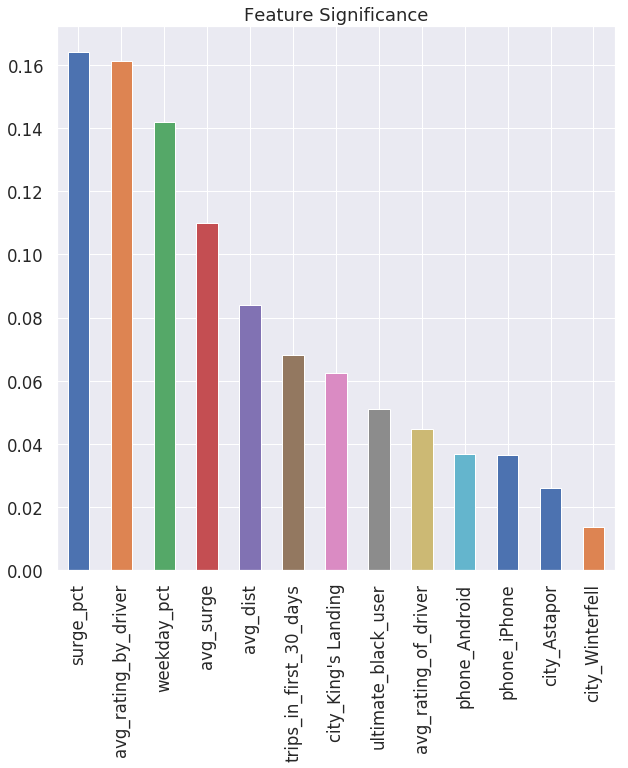

In [256]:
coef = pd.Series(cl_rand_fr.feature_importances_, index = df_columns).sort_values(ascending=False)

plt.figure(figsize=(10, 10))
coef.head(13).plot(kind='bar')
plt.title('Feature Significance')

Feature importance results reveal that five most important features are surge_pct, avg_rating_by_driver, weekday_pct, avg_surge and avg_dist. This results can be taken into consideration when offering promotional deals to non-active users for taking more rides. 